# Test U-Net3+ on validation & test sets

In [1]:
!wget https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stain_utils.py
!wget https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stainNorm_Macenko.py
!pip install spams

--2023-02-04 09:11:31--  https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stain_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4255 (4.2K) [text/plain]
Saving to: ‘stain_utils.py’

stain_utils.py      100%[===================>]   4.16K  --.-KB/s    in 0s      

2023-02-04 09:11:31 (29.7 MB/s) - ‘stain_utils.py’ saved [4255/4255]

--2023-02-04 09:11:31--  https://raw.githubusercontent.com/wanghao14/Stain_Normalization/master/stainNorm_Macenko.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2663 (2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import time
import os
import cv2
import numpy as np
import pandas as pd
import glob
import random
import shutil
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import stain_utils as utils
import stainNorm_Macenko

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from skimage import filters
from skimage.color import label2rgb
from skimage import morphology
from scipy.ndimage import measurements
from skimage.segmentation import watershed, mark_boundaries

from scipy.optimize import linear_sum_assignment

## Defining the model

In [4]:
from keras.models import Model
from keras.applications import VGG19
from keras.layers import Input, Activation, UpSampling2D, concatenate, MaxPool2D
from keras.layers import Conv2D, BatchNormalization
from keras.regularizers import l2
from keras.initializers import he_normal

In [5]:
# https://github.com/hamidriasat/UNet-3-Plus/blob/unet3p_lits/models/unet3plus_deep_supervision.py

def conv_block(x, kernels, kernel_size=(3, 3), strides=(1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv2d:
        Apply  3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = Conv2D(filters=kernels, kernel_size=kernel_size,
                   padding=padding, strides=strides,
                   kernel_regularizer=l2(1e-4),
                   kernel_initializer=he_normal(seed=5))(x)
        if is_bn:
            x = BatchNormalization()(x)
        if is_relu:
            x = Activation("relu")(x)

    return x

def unet3plus_deepsup(input_shape, deep_supervision=False):
    """ UNet_3Plus with Deep Supervision """
    # filters = [64, 128, 256, 512, 1024]
    filters = [16, 32, 64, 128, 256]

    input_layer = Input(shape=input_shape, name="input_layer")  # 320*320*3

    """ Encoder"""
    skip_connections = []

    model = VGG19(include_top=False, weights="imagenet", input_tensor=input_layer)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output

    # block 5
    # bottleneck layer
    e5 = conv_block(output, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4_1 """
    e1_d4_1 = MaxPool2D(pool_size=(8, 8))(skip_connections[0])  # 320*320*64  --> 40*40*64
    e1_d4_1 = conv_block(e1_d4_1, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4_1 = MaxPool2D(pool_size=(4, 4))(skip_connections[1])  # 160*160*128 --> 40*40*128
    e2_d4_1 = conv_block(e2_d4_1, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4_1 = MaxPool2D(pool_size=(2, 2))(skip_connections[2])  # 80*80*256  --> 40*40*256
    e3_d4_1 = conv_block(e3_d4_1, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4_1 = conv_block(skip_connections[3], cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4_1 = conv_block(e5_d4_1, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4_1 = concatenate([e1_d4_1, e2_d4_1, e3_d4_1, e4_d4_1, e5_d4_1])
    d4_1 = conv_block(d4_1, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3_1 """
    e1_d3_1 = MaxPool2D(pool_size=(4, 4))(skip_connections[0])  # 320*320*64 --> 80*80*64
    e1_d3_1 = conv_block(e1_d3_1, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3_1 = MaxPool2D(pool_size=(2, 2))(skip_connections[1])  # 160*160*256 --> 80*80*256
    e2_d3_1 = conv_block(e2_d3_1, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3_1 = conv_block(skip_connections[2], cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d4_1)  # 40*40*320 --> 80*80*320
    e4_d3_1 = conv_block(e4_d3_1, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3_1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3_1 = conv_block(e5_d3_1, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3_1 = concatenate([e1_d3_1, e2_d3_1, e3_d3_1, e4_d3_1, e5_d3_1])
    d3_1 = conv_block(d3_1, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2_1 """
    e1_d2_1 = MaxPool2D(pool_size=(2, 2))(skip_connections[0])  # 320*320*64 --> 160*160*64
    e1_d2_1 = conv_block(e1_d2_1, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2_1 = conv_block(skip_connections[1], cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d3_1)  # 80*80*320 --> 160*160*320
    d3_d2_1 = conv_block(d3_d2_1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2_1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d4_1)  # 40*40*320 --> 160*160*320
    d4_d2_1 = conv_block(d4_d2_1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2_1 = UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2_1 = conv_block(e5_d2_1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2_1 = concatenate([e1_d2_1, e2_d2_1, d3_d2_1, d4_d2_1, e5_d2_1])
    d2_1 = conv_block(d2_1, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1_1 """
    e1_d1_1 = conv_block(skip_connections[0], cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d2_1)  # 160*160*320 --> 320*320*320
    d2_d1_1 = conv_block(d2_d1_1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1_1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d3_1)  # 80*80*320 --> 320*320*320
    d3_d1_1 = conv_block(d3_d1_1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1_1 = UpSampling2D(size=(8, 8), interpolation='bilinear')(d4_1)  # 40*40*320 --> 320*320*320
    d4_d1_1 = conv_block(d4_d1_1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1_1 = UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1_1 = conv_block(e5_d1_1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1_1 = concatenate([e1_d1_1, d2_d1_1, d3_d1_1, d4_d1_1, e5_d1_1, ])
    d1_1 = conv_block(d1_1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batch norm and relu
    d1_1 = conv_block(d1_1, 1, n=1, is_bn=False, is_relu=False)
    d1_1 = Activation("sigmoid", name="binary_final")(d1_1)

    """ d4_2 """
    e1_d4_2 = MaxPool2D(pool_size=(8, 8))(skip_connections[0])  # 320*320*64  --> 40*40*64
    e1_d4_2 = conv_block(e1_d4_2, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4_2 = MaxPool2D(pool_size=(4, 4))(skip_connections[1])  # 160*160*128 --> 40*40*128
    e2_d4_2 = conv_block(e2_d4_2, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4_2 = MaxPool2D(pool_size=(2, 2))(skip_connections[2])  # 80*80*256  --> 40*40*256
    e3_d4_2 = conv_block(e3_d4_2, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4_2 = conv_block(skip_connections[3], cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(e5)  # 80*80*256  --> 40*40*256
    e5_d4_2 = conv_block(e5_d4_2, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4_2 = concatenate([e1_d4_2, e2_d4_2, e3_d4_2, e4_d4_2, e5_d4_2])
    d4_2 = conv_block(d4_2, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3_2 """
    e1_d3_2 = MaxPool2D(pool_size=(4, 4))(skip_connections[0])  # 320*320*64 --> 80*80*64
    e1_d3_2 = conv_block(e1_d3_2, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3_2 = MaxPool2D(pool_size=(2, 2))(skip_connections[1])  # 160*160*256 --> 80*80*256
    e2_d3_2 = conv_block(e2_d3_2, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3_2 = conv_block(skip_connections[2], cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d4_2)  # 40*40*320 --> 80*80*320
    e4_d3_2 = conv_block(e4_d3_2, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3_2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(e5)  # 20*20*320 --> 80*80*320
    e5_d3_2 = conv_block(e5_d3_2, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3_2 = concatenate([e1_d3_2, e2_d3_2, e3_d3_2, e4_d3_2, e5_d3_2])
    d3_2 = conv_block(d3_2, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2_2 """
    e1_d2_2 = MaxPool2D(pool_size=(2, 2))(skip_connections[0])  # 320*320*64 --> 160*160*64
    e1_d2_2 = conv_block(e1_d2_2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2_2 = conv_block(skip_connections[1], cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d3_2)  # 80*80*320 --> 160*160*320
    d3_d2_2 = conv_block(d3_d2_2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2_2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d4_2)  # 40*40*320 --> 160*160*320
    d4_d2_2 = conv_block(d4_d2_2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2_2 = UpSampling2D(size=(8, 8), interpolation='bilinear')(e5)  # 20*20*320 --> 160*160*320
    e5_d2_2 = conv_block(e5_d2_2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2_2 = concatenate([e1_d2_2, e2_d2_2, d3_d2_2, d4_d2_2, e5_d2_2])
    d2_2 = conv_block(d2_2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1_2 """
    e1_d1_2 = conv_block(skip_connections[0], cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d2_2)  # 160*160*320 --> 320*320*320
    d2_d1_2 = conv_block(d2_d1_2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1_2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d3_2)  # 80*80*320 --> 320*320*320
    d3_d1_2 = conv_block(d3_d1_2, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1_2 = UpSampling2D(size=(8, 8), interpolation='bilinear')(d4_2)  # 40*40*320 --> 320*320*320
    d4_d1_2 = conv_block(d4_d1_2, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1_2 = UpSampling2D(size=(16, 16), interpolation='bilinear')(e5)  # 20*20*320 --> 320*320*320
    e5_d1_2 = conv_block(e5_d1_2, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1_2 = concatenate([e1_d1_2, d2_d1_2, d3_d1_2, d4_d1_2, e5_d1_2, ])
    d1_2 = conv_block(d1_2, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batch norm and relu
    d1_2 = conv_block(d1_2, 3, n=1, is_bn=False, is_relu=False)
    d1_2 = Activation("softmax", name="multi_final")(d1_2)

    """ Deep Supervision Part"""
    if deep_supervision:
        # Binary super-vision
        d2_1 = conv_block(d2_1, 1, n=1, is_bn=False, is_relu=False)
        d3_1 = conv_block(d3_1, 1, n=1, is_bn=False, is_relu=False)
        d4_1 = conv_block(d4_1, 1, n=1, is_bn=False, is_relu=False)
        e5_1 = conv_block(e5, 1, n=1, is_bn=False, is_relu=False)

        # d1_1 = no need for up sampling
        d2_1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d2_1)
        d3_1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d3_1)
        d4_1 = UpSampling2D(size=(8, 8), interpolation='bilinear')(d4_1)
        e5_1 = UpSampling2D(size=(16, 16), interpolation='bilinear')(e5_1)

        d2_1 = Activation("sigmoid", name="binary_sup1")(d2_1)
        d3_1 = Activation("sigmoid", name="binary_sup2")(d3_1)
        d4_1 = Activation("sigmoid", name="binary_sup3")(d4_1)
        e5_1 = Activation("sigmoid", name="binary_sup4")(e5_1)

        # Multi-class super-vision
        d2_2 = conv_block(d2_2, 3, n=1, is_bn=False, is_relu=False)
        d3_2 = conv_block(d3_2, 3, n=1, is_bn=False, is_relu=False)
        d4_2 = conv_block(d4_2, 3, n=1, is_bn=False, is_relu=False)
        e5_2 = conv_block(e5, 3, n=1, is_bn=False, is_relu=False)

        # d1_2 = no need for up sampling
        d2_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d2_2)
        d3_2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(d3_2)
        d4_2 = UpSampling2D(size=(8, 8), interpolation='bilinear')(d4_2)
        e5_2 = UpSampling2D(size=(16, 16), interpolation='bilinear')(e5_2)

        d2_2 = Activation("softmax", name="multi_sup1")(d2_2)
        d3_2 = Activation("softmax", name="multi_sup2")(d3_2)
        d4_2 = Activation("softmax", name="multi_sup3")(d4_2)
        e5_2 = Activation("softmax", name="multi_sup4")(e5_2)

    if deep_supervision:
        return Model(inputs=input_layer, outputs=[d1_1, d2_1, d3_1, d4_1, e5_1,
                                                  d1_2, d2_2, d3_2, d4_2, e5_2], name='UNet3Plus_DeepSup')
    else:
        return Model(inputs=input_layer, outputs=[d1_1, d1_2], name='UNet3Plus_DeepSup')

In [6]:
INPUT_SHAPE = [1024, 1024, 3]

model = unet3plus_deepsup(INPUT_SHAPE, deep_supervision=True)
# model.summary()

80134624/80134624 [==============================] - 4s 0us/step


In [7]:
%cd drive/MyDrive/nuclei_segmentation

/content/drive/.shortcut-targets-by-id/1hmfvFQhEFo3x6BgffnTQEBgnQdsN8Vqy/nuclei_segmentation


## Loading trained weights

In [8]:
# /content/drive/MyDrive/nuclei_segmentation/models/Unet3+/Unet3+_fold1_v00_20230107-073822.h5
# /content/drive/MyDrive/nuclei_segmentation/models/Unet3+/Unet3+_fold2_v00_20230107-074935.h5
# /content/drive/MyDrive/nuclei_segmentation/models/Unet3+/Unet3+_fold3_v00_20230107-075408.h5
# /content/drive/MyDrive/nuclei_segmentation/models/Unet3+/Unet3+_fold4_v00_20230107-075625.h5
# /content/drive/MyDrive/nuclei_segmentation/models/Unet3+/Unet3+_fold5_v00_20230107-101937.h5
# /content/drive/MyDrive/nuclei_segmentation/models/Unet3+/Unet3+_v00_20230118-095033.h5

model_path = "models/Unet3+/Unet3+_v00_20230118-095033.h5"
model.load_weights(model_path)

In [9]:
def  macenko_normalize(img_dir: str, ref_img_dir:str):
    # read image
    img = utils.read_image(img_dir)
    n = stainNorm_Macenko.Normalizer()
    # fit macenko normallizer on reference image
    n.fit(np.array(Image.open(ref_img_dir))) 
    # stain normalize H&E image
    normalized_img = n.transform(img)
    return img, normalized_img

In [10]:
# https://github.com/vqdang/hover_net/blob/master/metrics/stats_utils.py

def remap_label(pred, by_size=False):
    pred_id = list(np.unique(pred))
    pred_id.remove(0)
    if len(pred_id) == 0:
        return pred  # no label
    if by_size:
        pred_size = []
        for inst_id in pred_id:
            size = (pred == inst_id).sum()
            pred_size.append(size)
        # sort the id by size in descending order
        pair_list = zip(pred_id, pred_size)
        pair_list = sorted(pair_list, key=lambda x: x[1], reverse=True)
        pred_id, pred_size = zip(*pair_list)

    new_pred = np.zeros(pred.shape, np.int32)
    for idx, inst_id in enumerate(pred_id):
        new_pred[pred == inst_id] = idx + 1
    return new_pred

def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score

def get_fast_aji_plus(true, pred):
    """AJI+, an AJI version with maximal unique pairing to obtain overall intersecion.
    Every prediction instance is paired with at most 1 GT instance (1 to 1) mapping, unlike AJI 
    where a prediction instance can be paired against many GT instances (1 to many).
    Remaining unpaired GT and Prediction instances will be added to the overall union.
    The 1 to 1 mapping prevents AJI's over-penalisation from happening.
    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.
    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    #### Munkres pairing to find maximal unique pairing
    paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
    ### extract the paired cost and remove invalid pair
    paired_iou = pairwise_iou[paired_true, paired_pred]
    # now select all those paired with iou != 0.0 i.e have intersection
    paired_true = paired_true[paired_iou > 0.0]
    paired_pred = paired_pred[paired_iou > 0.0]
    paired_inter = pairwise_inter[paired_true, paired_pred]
    paired_union = pairwise_union[paired_true, paired_pred]
    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    overall_inter = paired_inter.sum()
    overall_union = paired_union.sum()
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score

def get_fast_pq(true, pred, match_iou=0.5):
    """`match_iou` is the IoU threshold level to determine the pairing between
    GT instances `p` and prediction instances `g`. `p` and `g` is a pair
    if IoU > `match_iou`. However, pair of `p` and `g` must be unique 
    (1 prediction instance to 1 GT instance mapping).
    If `match_iou` < 0.5, Munkres assignment (solving minimum weight matching
    in bipartite graphs) is caculated to find the maximal amount of unique pairing. 
    If `match_iou` >= 0.5, all IoU(p,g) > 0.5 pairing is proven to be unique and
    the number of pairs is also maximal.    
    
    Fast computation requires instance IDs are in contiguous orderding 
    i.e [1, 2, 3, 4] not [2, 3, 6, 10]. Please call `remap_label` beforehand 
    and `by_size` flag has no effect on the result.
    Returns:
        [dq, sq, pq]: measurement statistic
        [paired_true, paired_pred, unpaired_true, unpaired_pred]: 
                      pairing information to perform measurement
                    
    """
    assert match_iou >= 0.0, "Cant' be negative"

    true = np.copy(true)
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_iou = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise iou
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            iou = inter / (total - inter)
            pairwise_iou[true_id - 1, pred_id - 1] = iou
    #
    if match_iou >= 0.5:
        paired_iou = pairwise_iou[pairwise_iou > match_iou]
        pairwise_iou[pairwise_iou <= match_iou] = 0.0
        paired_true, paired_pred = np.nonzero(pairwise_iou)
        paired_iou = pairwise_iou[paired_true, paired_pred]
        paired_true += 1  # index is instance id - 1
        paired_pred += 1  # hence return back to original
    else:  # * Exhaustive maximal unique pairing
        #### Munkres pairing with scipy library
        # the algorithm return (row indices, matched column indices)
        # if there is multiple same cost in a row, index of first occurence
        # is return, thus the unique pairing is ensure
        # inverse pair to get high IoU as minimum
        paired_true, paired_pred = linear_sum_assignment(-pairwise_iou)
        ### extract the paired cost and remove invalid pair
        paired_iou = pairwise_iou[paired_true, paired_pred]

        # now select those above threshold level
        # paired with iou = 0.0 i.e no intersection => FP or FN
        paired_true = list(paired_true[paired_iou > match_iou] + 1)
        paired_pred = list(paired_pred[paired_iou > match_iou] + 1)
        paired_iou = paired_iou[paired_iou > match_iou]

    # get the actual FP and FN
    unpaired_true = [idx for idx in true_id_list[1:] if idx not in paired_true]
    unpaired_pred = [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    # print(paired_iou.shape, paired_true.shape, len(unpaired_true), len(unpaired_pred))

    #
    tp = len(paired_true)
    fp = len(unpaired_pred)
    fn = len(unpaired_true)
    # get the F1-score i.e DQ
    dq = tp / (tp + 0.5 * fp + 0.5 * fn)
    # get the SQ, no paired has 0 iou so not impact
    sq = paired_iou.sum() / (tp + 1.0e-6)

    return [dq, sq, dq * sq], [paired_true, paired_pred, unpaired_true, unpaired_pred]


#####
def get_fast_dice_2(true, pred):
    """Ensemble dice."""
    true = np.copy(true)
    pred = np.copy(pred)
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))

    overall_total = 0
    overall_inter = 0

    true_masks = [np.zeros(true.shape)]
    for t in true_id[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [np.zeros(true.shape)]
    for p in pred_id[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    for true_idx in range(1, len(true_id)):
        t_mask = true_masks[true_idx]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        try:  # blinly remove background
            pred_true_overlap_id.remove(0)
        except ValueError:
            pass  # just mean no background
        for pred_idx in pred_true_overlap_id:
            p_mask = pred_masks[pred_idx]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            overall_total += total
            overall_inter += inter

    return 2 * overall_inter / overall_total


#####--------------------------As pseudocode
def get_dice_1(true, pred):
    """Traditional dice."""
    # cast to binary 1st
    true = np.copy(true)
    pred = np.copy(pred)
    true[true > 0] = 1
    pred[pred > 0] = 1
    inter = true * pred
    denom = true + pred
    return 2.0 * np.sum(inter) / np.sum(denom)


####
def get_dice_2(true, pred):
    """Ensemble Dice as used in Computational Precision Medicine Challenge."""
    true = np.copy(true)
    pred = np.copy(pred)
    true_id = list(np.unique(true))
    pred_id = list(np.unique(pred))
    # remove background aka id 0
    true_id.remove(0)
    pred_id.remove(0)

    total_markup = 0
    total_intersect = 0
    for t in true_id:
        t_mask = np.array(true == t, np.uint8)
        for p in pred_id:
            p_mask = np.array(pred == p, np.uint8)
            intersect = p_mask * t_mask
            if intersect.sum() > 0:
                total_intersect += intersect.sum()
                total_markup += t_mask.sum() + p_mask.sum()
    return 2 * total_intersect / total_markup

In [11]:
# https://github.com/ykrmm/monuseg/blob/main/eval_train/aji_metric.py

class AJI_Metrics(object):
    def __init__(self,threshold=54) -> None:
        self.aji = [] # aji metrics 
        self.threshold = threshold # nuclei less than threshold size will be supressed in post processing cleaning 

    def add_prediction(self,labels_pred,gt):
        """
            Input labels_pred -> np.array Watershed prediction or instance segmentation mask 
            gt -> torch.Tensor Ground truth
        """
        intersection = 0
        union = 0
        # gt = gt.squeeze()
        # gt = gt.detach().cpu().numpy()

        #print('LEN DE PRED',len(np.unique(labels_pred)))


        markers_pred = np.zeros(np.shape(np.unique(labels_pred)))  # 0 if unmarked 1 if marked 
        list_g = np.unique(gt)
        #print('LEN GT',len(list_g))
        markers_pred[0] = 1 # Mark background as used
        
        for g in list_g[1:]: # Don't take the label 0 (background)
            mask_g = np.where(gt!=g,0,gt)
            res = np.where(mask_g == g ) # Coord where the nuclei g is in the ground truth mask 
            #print('Ground truth',g)
            #print('RES',res,'LEN de RES',len(res[0]))
            #print('COUNT G IN GT',np.count_nonzero(gt ==g),'COUNT G IN PRED',np.count_nonzero(labels_pred==g))
            overlap = []
            for i in range(len(res[0])):
                coord = (res[0][i],res[1][i])
                overlap.append(labels_pred[coord]) 

            overlap = np.unique(overlap) # Get overlap nuclei in pred masks 
            #print('OVERLAP',overlap)
            #print('LEN OVERLAP',len(overlap))
            iou = []
            l_inter = []
            l_union = []
            all_marked = True
            for i,s in enumerate(overlap):
                if markers_pred[s] ==0:
                    mask_s = np.where(labels_pred!=s,0,labels_pred)
                    inter = len(np.where((mask_g>0) & (mask_s>0))[0])
                    u = len(np.where((mask_g>0) | (mask_s>0))[0])
                    l_inter.append(inter)
                    l_union.append(u)
                    iou_score = inter / u
                    iou.append(iou_score)
                    all_marked = False # If all overlap object are marked -> then we have to add the GT nuclei to the union
                else:
                    inter = 0
                    u = 0
                    l_inter.append(inter)
                    l_union.append(u)
                    iou_score = 0
                    iou.append(iou_score)
            if all_marked:
                occurence = np.count_nonzero(gt ==g) # If overlap is only marked nuclei, add the GT to the union 
                union+= occurence
                #print('Overlap nuclei list of nuclei',g,'is only marked nuclei')
            try:
                
                best = np.argmax(iou)
                best_s = overlap[best]
                #print('BEST S',best_s) 
                intersection += l_inter[best]
                union += l_union[best]
                markers_pred[best_s] = 1 # Mark the best nuclei used
            except:
                occurence = np.count_nonzero(gt ==g) # If overlap is empty, then its a false positive 
                union+= occurence
                print('Overlap nuclei list of nuclei',g,'is empty')

        # Add to union every pred segmented nuclei unused
        #print('before union',float(intersection)/float(union))
        #print('Element unmarked',np.count_nonzero(markers_pred == 0),'element in markers_pred',len(markers_pred))
        for i,m in enumerate(markers_pred):
            if m ==0 : 
                occurence = np.count_nonzero(labels_pred ==i)
                union+= occurence

        aji = float(intersection)/float(union)
        self.aji.append(aji)
        return aji

    def get_aji(self):
        "When all aji are computed on the dataset, This function return the average aji"

        return np.array(self.aji).mean()  # Average of AJI
    

    def get_all_aji(self):
        return self.aji

## Evaluate the model on the validation set

In [12]:
def create_path(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [13]:
def make_validation_set(val_dir, train_dir, val_size=6, seed=42, fold=None):

    create_path(val_dir)
    create_path(os.path.join(val_dir, "tissue_images"))
    create_path(os.path.join(val_dir, "binary_masks"))
    create_path(os.path.join(val_dir, "instance_masks"))
    create_path(os.path.join(val_dir, "modified_masks"))
    
    for j in sorted(glob.glob(os.path.join(val_dir, "tissue_images", "*"))):
        try:
            shutil.move(j, os.path.join(train_dir, "tissue_images"))
            shutil.move(j.replace("tissue_images", "binary_masks").replace("tif", "png"), 
                        os.path.join(train_dir, "binary_masks"))
            shutil.move(j.replace("tissue_images", "instance_masks").replace("tif", "npy"), 
                        os.path.join(train_dir, "instance_masks"))
            shutil.move(j.replace("tissue_images", "modified_masks").replace("tif", "png"), 
                        os.path.join(train_dir, "modified_masks"))
        except:
            continue

    images_lst = sorted(glob.glob(os.path.join(train_dir, "tissue_images", "*")))
    np.random.seed(seed)
    np.random.shuffle(images_lst)
    if fold is None:
        random.seed(seed)
        val_lst = random.sample(images_lst, val_size)
    else:
        val_lst = images_lst[(fold*val_size)-val_size: fold*val_size]
        

    for i in val_lst:
        shutil.move(i, os.path.join(val_dir, "tissue_images"))
        shutil.move(i.replace("tissue_images", "binary_masks").replace("tif", "png"), 
                    os.path.join(val_dir, "binary_masks"))
        shutil.move(i.replace("tissue_images", "instance_masks").replace("tif", "npy"), 
                    os.path.join(val_dir, "instance_masks"))
        shutil.move(i.replace("tissue_images", "modified_masks").replace("tif", "png"), 
                    os.path.join(val_dir, "modified_masks"))
        
    print(f"Validation list: {[os.path.basename(i) for i in val_lst]}")

In [14]:
train_dir = "dataset/monuseg/stain_normalized/train"
val_dir = "dataset/monuseg/stain_normalized/validation"

In [15]:
make_validation_set(val_dir, train_dir, val_size=6, fold=5)

Validation list: ['TCGA-G9-6348-01Z-00-DX1.tif', 'TCGA-A7-A13F-01Z-00-DX1.tif', 'TCGA-AY-A8YK-01A-01-TS1.tif', 'TCGA-CH-5767-01Z-00-DX1.tif', 'TCGA-G9-6336-01Z-00-DX1.tif', 'TCGA-A7-A13E-01Z-00-DX1.tif']


In [16]:
ref_img_dir = "dataset/monuseg/original/train/tissue_images/TCGA-AR-A1AS-01Z-00-DX1.tif"

In [17]:
val_img_dir = "dataset/monuseg/stain_normalized/validation/tissue_images"
val_mask_dir = "dataset/monuseg/stain_normalized/validation/binary_masks"
val_multi_gt_dir = "dataset/monuseg/stain_normalized/validation/modified_masks"
val_instance_gt_path = "dataset/monuseg/stain_normalized/validation/instance_masks"

In [18]:
BINARY_SCORE = []
MULTICLASS_SCORE = []
FINAL_SCORE = []

pred_time = 0
tta_time = 0
post_proc_time = 0

for image_path in tqdm(glob.glob(os.path.join(val_img_dir, "*")), total=len(os.listdir(val_img_dir))):
    """ extracting the name """
    name = os.path.basename(image_path)
    name = name.split(".")[0]

    """ preprocessing """
    # 1) read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 2) resize to 1024 * 1024
    resizedI = cv2.resize(img, (1024, 1024), cv2.INTER_LINEAR)
    # 3) pixel value normalize between [0, 1]
    normalizedI = resizedI.astype("float32") / 255.
    # 4) expand dimension
    normalizedI = np.expand_dims(normalizedI, axis=0)

    """ make prediction """
    # pred = model.predict(normalizedI, verbose=0)
    # make prediction with TTA (Test Time Augmentation)
    start = time.time()
    pred = model.predict(normalizedI, verbose=0)
    end = time.time()
    pred_time += end - start
    binary_pred_org = pred[0]
    multi_pred_org = pred[5]
    
    pred_lr = model.predict(np.fliplr(normalizedI), verbose=0)
    binary_pred_lr = pred_lr[0]
    multi_pred_lr = pred_lr[5]
    binary_pred_lr = np.fliplr(binary_pred_lr)
    multi_pred_lr = np.fliplr(multi_pred_lr)

    pred_ud = model.predict(np.flipud(normalizedI), verbose=0)
    binary_pred_ud = pred_ud[0]
    multi_pred_ud = pred_ud[5]
    binary_pred_ud = np.flipud(binary_pred_ud)
    multi_pred_ud = np.flipud(multi_pred_ud)

    pred_lr_ud = model.predict(np.fliplr(np.flipud(normalizedI)), verbose=0)
    binary_pred_lr_ud = pred_lr_ud[0]
    multi_pred_lr_ud = pred_lr_ud[5]
    binary_pred_lr_ud = np.fliplr(np.flipud(binary_pred_lr_ud))
    multi_pred_lr_ud = np.fliplr(np.flipud(multi_pred_lr_ud))

    binary_pred = (binary_pred_org + binary_pred_lr + binary_pred_ud + binary_pred_lr_ud) / 4
    multi_pred = (multi_pred_org + multi_pred_lr + multi_pred_ud + multi_pred_lr_ud) / 4
    end = time.time()
    tta_time += end - start

    # resize to 1000 * 1000
    resized_pred_1 = cv2.resize(binary_pred.squeeze(), (1000, 1000))
    resized_pred_2 = cv2.resize(multi_pred.squeeze(), (1000, 1000))

    # threshold
    start = time.time()
    pred = resized_pred_1 >= 0.5
    pred = pred.astype("int32")

    pred_2 = resized_pred_2 >= 0.5
    pred_2 = pred_2.astype("int32")
    onehot_mask = np.argmax(pred_2, axis=-1)

    # post_processing
    marker_pred = (resized_pred_2[:, :, 2] - resized_pred_2[:, :, 1]) >= 0.5
    marker_pred = morphology.binary_erosion(marker_pred)
    marker_pred = marker_pred.astype("int32")

    grad = filters.scharr(pred)
    marker = pred * marker_pred
    marker = measurements.label(marker)[0]
    proced_pred = watershed(grad, marker, mask=pred)
    proced_pred = morphology.remove_small_objects(proced_pred, 100)
    binary_objects = proced_pred.astype(bool)
    binary_filled = morphology.remove_small_holes(binary_objects, 40)
    proced_pred = watershed(binary_filled, proced_pred, mask=binary_filled)
    end = time.time()
    post_proc_time += end - start

    # read the mask
    binary_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "binary_masks").replace("tif", "png")
    binary_gt = cv2.imread(binary_mask_path, 0)

    multi_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "modified_masks").replace("tif", "png")
    multi_gt = cv2.imread(multi_mask_path, 0)
    multi_gt[multi_gt==255] = 2
    multi_gt[multi_gt==127] = 1

    instance_gt_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "instance_masks").replace("tif", "npy")
    ins_gt = np.load(instance_gt_path)

    # evaluate
    mask = binary_gt.flatten()
    y_pred = pred.flatten()

    f1_value = f1_score(mask/255, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask/255, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)

    mask_2 = multi_gt.flatten()
    y_pred_2 = onehot_mask.flatten()

    f1_value_2 = f1_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    jac_value_2 = jaccard_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    recall_value_2 = recall_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)
    precision_value_2 = precision_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)

    proced_pred = remap_label(proced_pred)
    gt_remap = remap_label(ins_gt.astype("int32"))
    fast_aji = get_fast_aji(gt_remap, proced_pred)
    aji = AJI_Metrics()
    reg_aji= aji.add_prediction(proced_pred, ins_gt)
    score = get_fast_pq(gt_remap, proced_pred)
    dice_score = get_dice_1(gt_remap, proced_pred)
    dice2 = get_fast_dice_2(gt_remap, proced_pred)
    
    # append to SCORE
    BINARY_SCORE.append([name, f1_value, jac_value, recall_value, precision_value])
    val_binary_df = pd.DataFrame(BINARY_SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])

    MULTICLASS_SCORE.append([
                             name, 
                             f1_value_2[0], f1_value_2[1], f1_value_2[2],
                             jac_value_2[0], jac_value_2[1], jac_value_2[2],
                             recall_value_2[0], recall_value_2[1], recall_value_2[2],
                             precision_value_2[0], precision_value_2[1], precision_value_2[2],
                             ])
    val_multi_class_df = pd.DataFrame(MULTICLASS_SCORE, columns=["Image", 
                                                             "F1_bg", "F1_border", "F1_marker",
                                                             "Jaccard_bg", "Jaccard_border", "Jaccard_marker",
                                                             "Recall_bg", "Recall_border", "Recall_marker",
                                                             "Precision_bg", "Precision_border", "Precision_marker"])
    
    FINAL_SCORE.append([name, fast_aji, reg_aji, score[0][0], score[0][1], score[0][2], dice_score, dice2])
    val_final_df = pd.DataFrame(FINAL_SCORE, columns=["Image", "fast_AJI", "AJI", "DQ/F1", "SQ", "PQ", "DICE", "DICE2"])

100%|██████████| 6/6 [02:27<00:00, 24.66s/it]


In [19]:
print(f"Prediction time: {pred_time/6:.3f}s, TTA time: {tta_time/6:.3f}s, Post_processing time: {post_proc_time/6:.3f}s")

Prediction time: 4.546s, TTA time: 6.464s, Post_processing time: 0.140s


In [20]:
val_binary_df.loc['mean'] = val_binary_df.mean(numeric_only=True)
# binary_df.to_csv("binary_score_FTL.csv")
val_binary_df

Image        F1   Jaccard    Recall  Precision
0     TCGA-G9-6348-01Z-00-DX1  0.914408  0.842312  0.929184   0.900094
1     TCGA-CH-5767-01Z-00-DX1  0.895730  0.811151  0.924809   0.868424
2     TCGA-G9-6336-01Z-00-DX1  0.918583  0.849425  0.935133   0.902608
3     TCGA-A7-A13F-01Z-00-DX1  0.910326  0.835411  0.936813   0.885295
4     TCGA-AY-A8YK-01A-01-TS1  0.864761  0.761744  0.915570   0.819295
5     TCGA-A7-A13E-01Z-00-DX1  0.878445  0.783239  0.895736   0.861810
mean                      NaN  0.897042  0.813880  0.922874   0.872921

In [21]:
val_multi_class_df.loc['mean'] = val_multi_class_df.mean(numeric_only=True)
# multi_class_df.to_csv("multi_class_FTL.csv")
val_multi_class_df

Image     F1_bg  F1_border  F1_marker  Jaccard_bg  \
0     TCGA-G9-6348-01Z-00-DX1  0.968604   0.839989   0.889627    0.939119   
1     TCGA-CH-5767-01Z-00-DX1  0.970291   0.770822   0.868306    0.942297   
2     TCGA-G9-6336-01Z-00-DX1  0.957684   0.796738   0.876330    0.918803   
3     TCGA-A7-A13F-01Z-00-DX1  0.975671   0.831674   0.877985    0.952497   
4     TCGA-AY-A8YK-01A-01-TS1  0.928759   0.759092   0.838903    0.866994   
5     TCGA-A7-A13E-01Z-00-DX1  0.963910   0.783214   0.857918    0.930335   
mean                      NaN  0.960820   0.796921   0.868178    0.925007   

      Jaccard_border  Jaccard_marker  Recall_bg  Recall_border  Recall_marker  \
0           0.724121        0.801196   0.971232       0.839118       0.879795   
1           0.627103        0.767263   0.968821       0.776032       0.868667   
2           0.662148        0.779882   0.961839       0.797832       0.866421   
3           0.711852        0.782507   0.975238       0.821404       0.897117   
4           0.611723        0.722509   0.916280       0.757629       0.873889   
5           0.643674        0.751188   0.958842       0.807706       0.847756   
mean        0.663437        0.767424   0.958709       0.799953       0.872274   

      Precision_bg  Precision_border  Precision_marker  
0         0.965990          0.840862          0.899681  
1         0.971766          0.765680          0.867946  
2         0.953564          0.795646          0.886469  
3         0.976104          0.842205          0.859652  
4         0.941583          0.760561          0.806611  
5         0.969032          0.760163          0.868327  
mean      0.963006          0.794186          0.864781

In [22]:
create_path("results/Unet3+")

In [23]:
val_final_df.loc['mean'] = val_final_df.mean(numeric_only=True)
# val_final_df.to_csv("results/Unet3+/final_score_fold5.csv")
val_final_df

Image  fast_AJI       AJI     DQ/F1        SQ  \
0     TCGA-G9-6348-01Z-00-DX1  0.790224  0.794400  0.927203  0.841280   
1     TCGA-CH-5767-01Z-00-DX1  0.742146  0.742284  0.904202  0.808930   
2     TCGA-G9-6336-01Z-00-DX1  0.743575  0.752666  0.925170  0.815072   
3     TCGA-A7-A13F-01Z-00-DX1  0.742701  0.738586  0.927247  0.820533   
4     TCGA-AY-A8YK-01A-01-TS1  0.674713  0.674190  0.855586  0.778412   
5     TCGA-A7-A13E-01Z-00-DX1  0.746719  0.746892  0.896861  0.800439   
mean                      NaN  0.740013  0.741503  0.906045  0.810778   

            PQ      DICE     DICE2  
0     0.780037  0.914944  0.721603  
1     0.731436  0.896873  0.579242  
2     0.754080  0.919183  0.520908  
3     0.760836  0.909947  0.762684  
4     0.665998  0.863712  0.711469  
5     0.717882  0.879009  0.800863  
mean  0.735045  0.897278  0.682795

## Evaluate the model on the test set

In [24]:
test_img_dir = "dataset/monuseg/original/test/tissue_images"
test_mask_dir = "dataset/monuseg/stain_normalized/test/binary_masks"
test_multi_gt_dir = "dataset/monuseg/stain_normalized/test/modified_masks"
test_instance_gt_path = "dataset/monuseg/stain_normalized/test/instance_masks"

In [25]:
test_organs = ["Kidney", "Lung", "Lung", "Colon", "Breast", "Breast", "Bladder", 
               "Prostate", "Brain", "Kidney", "Prostate", "Brain", "Kidney", "Bladder"]

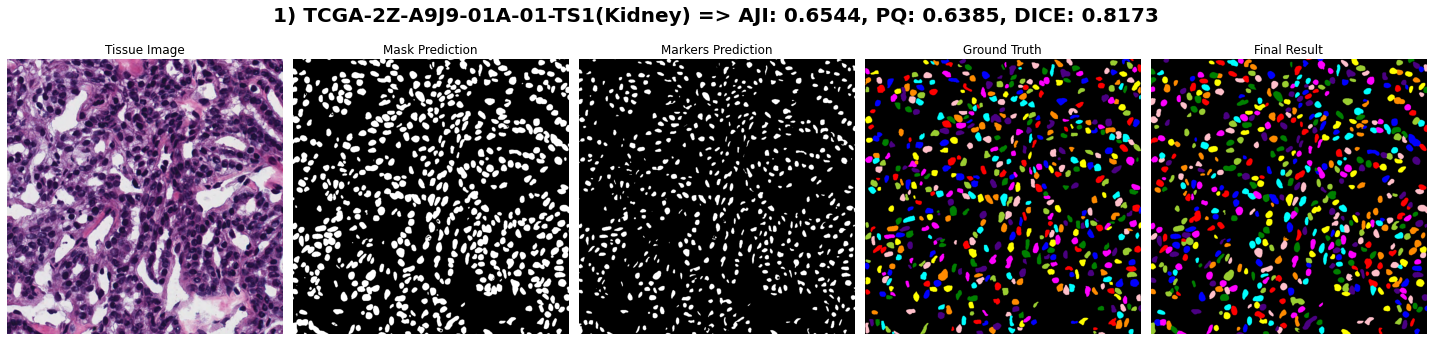

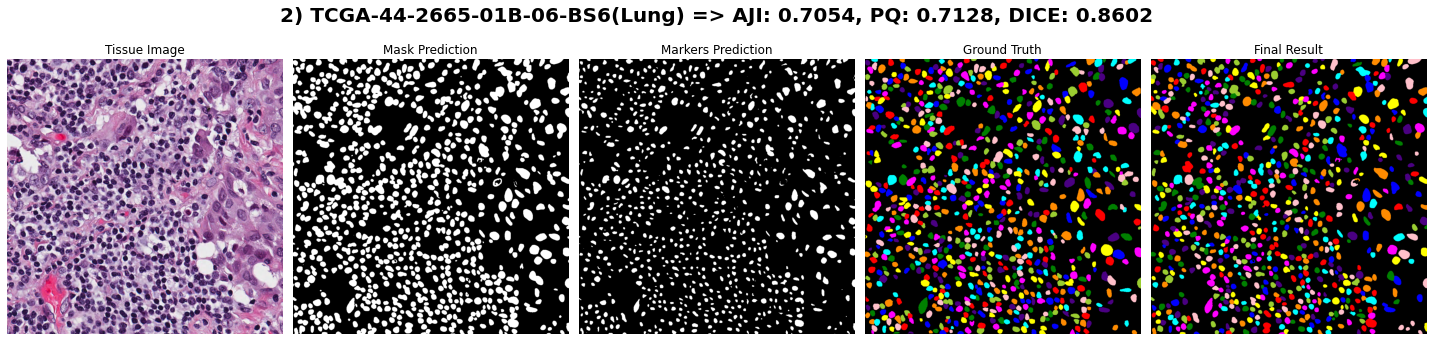

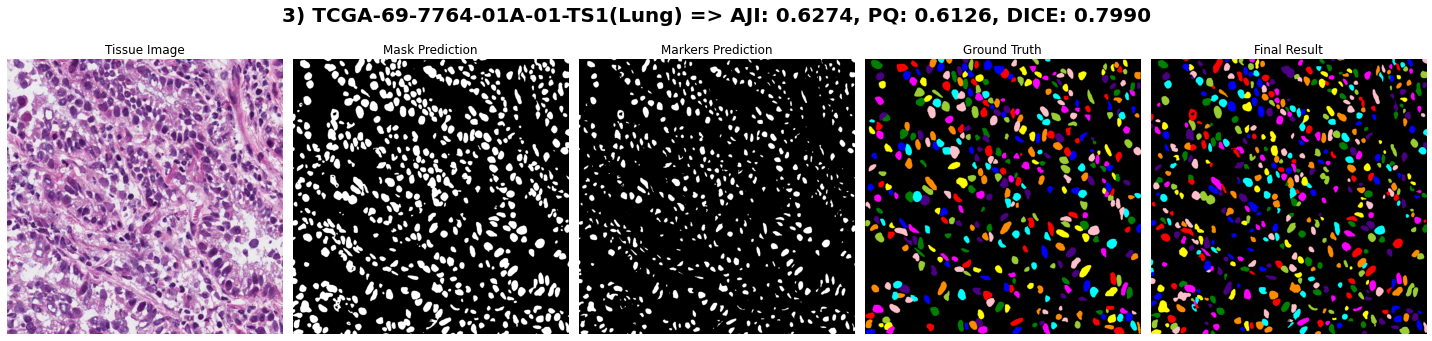

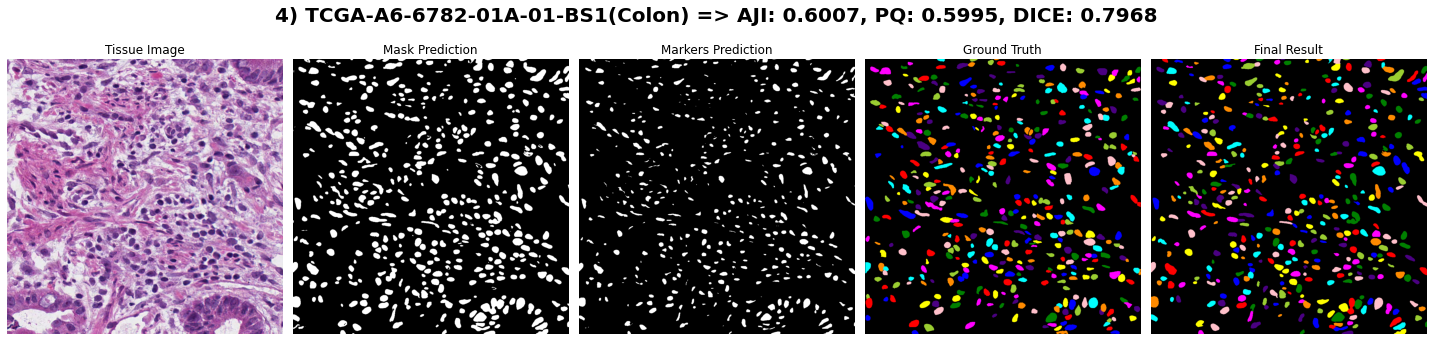

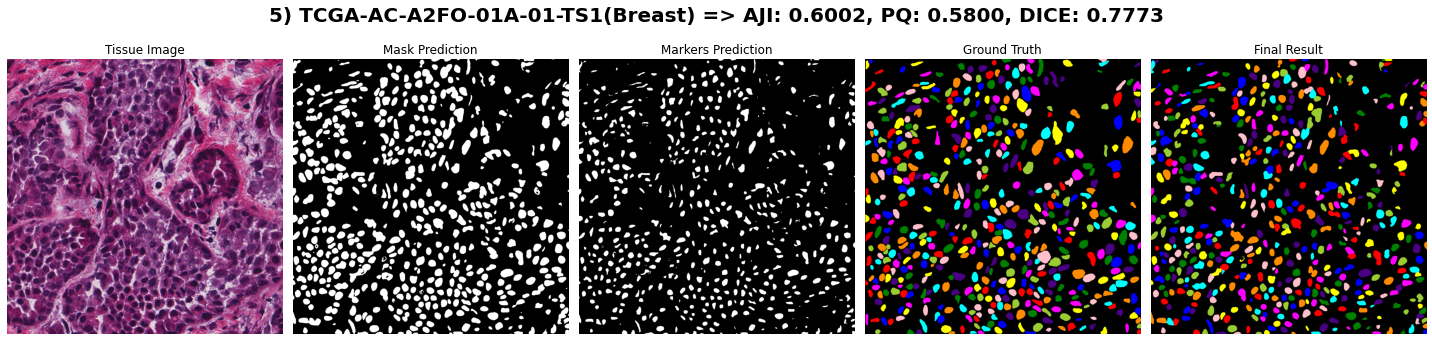

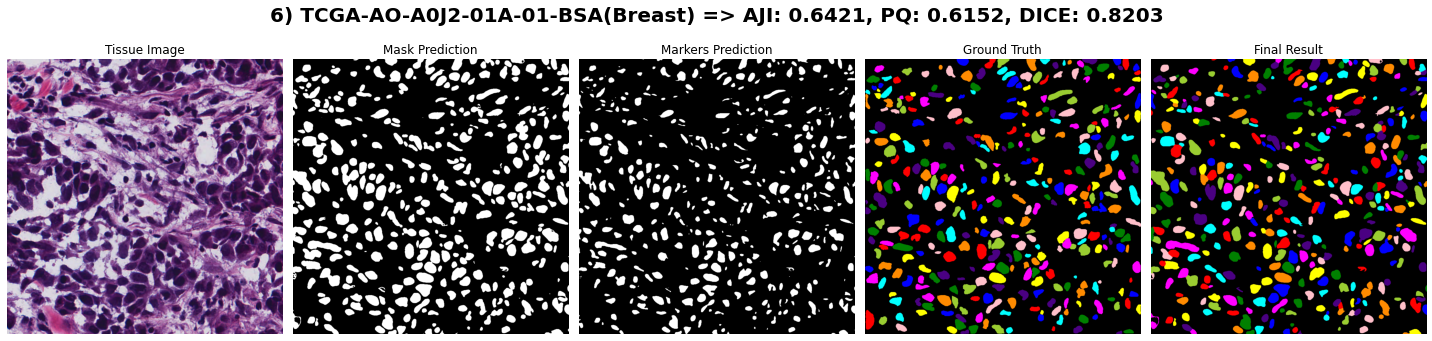

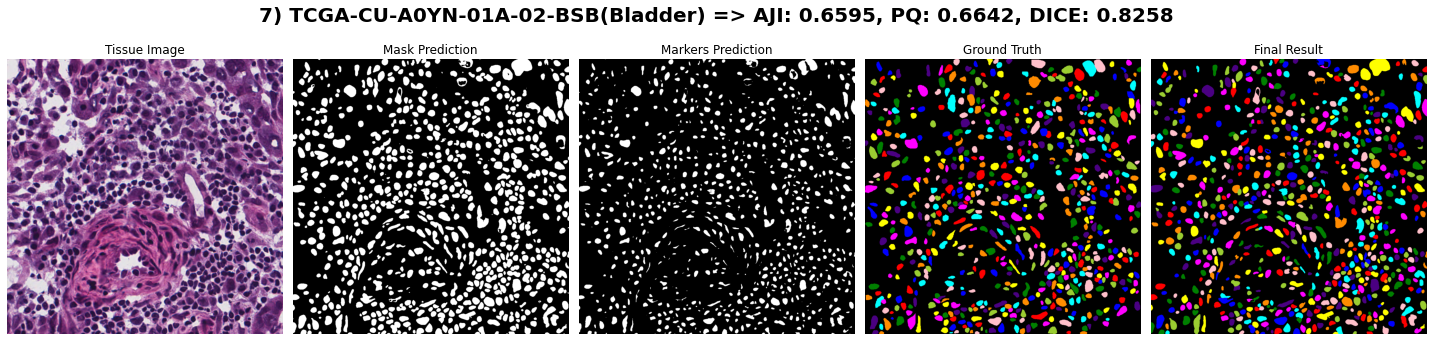

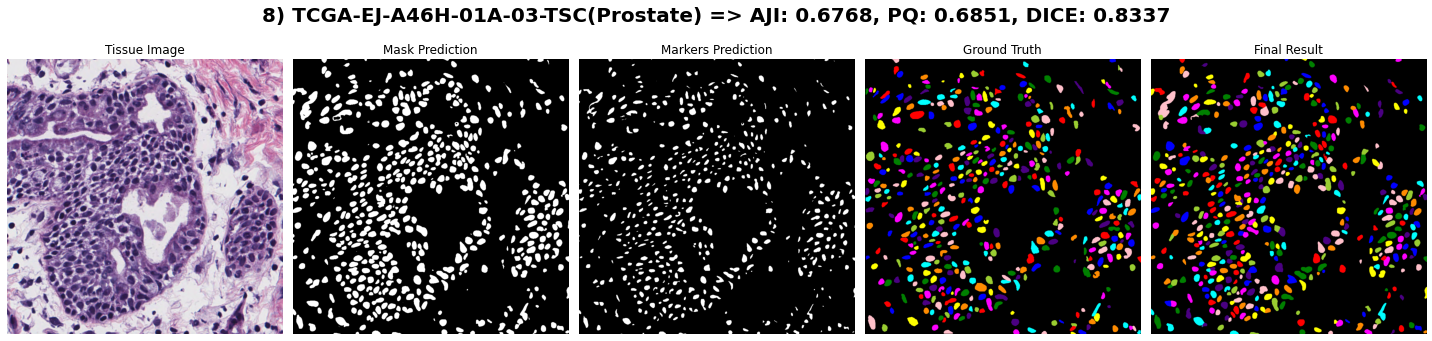

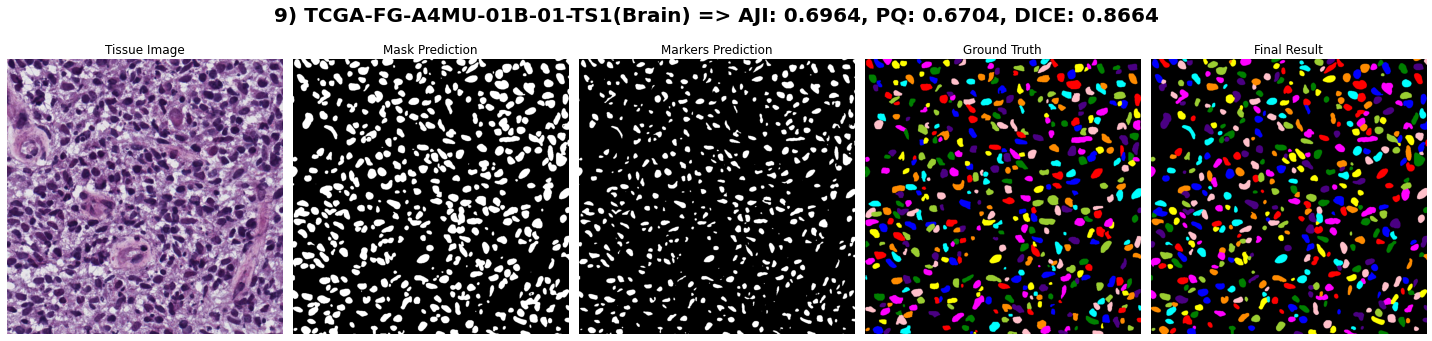

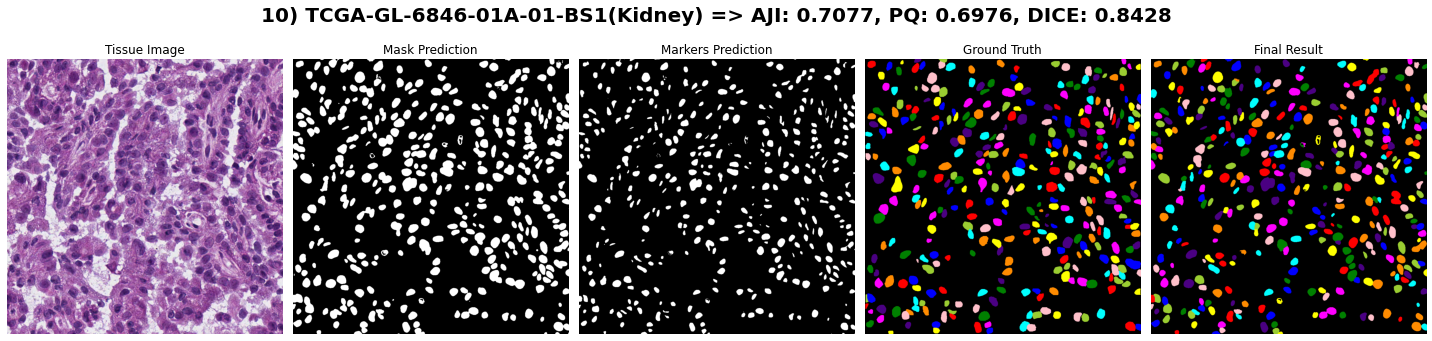

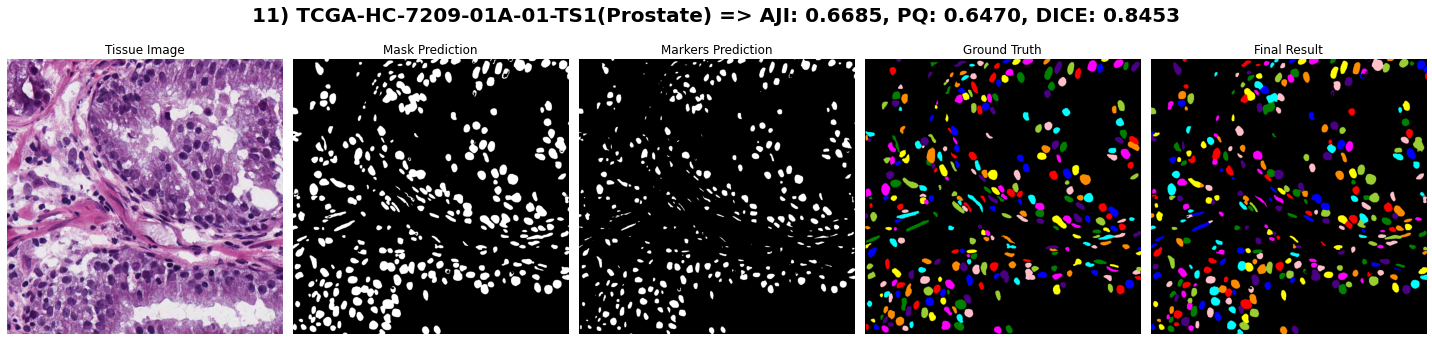

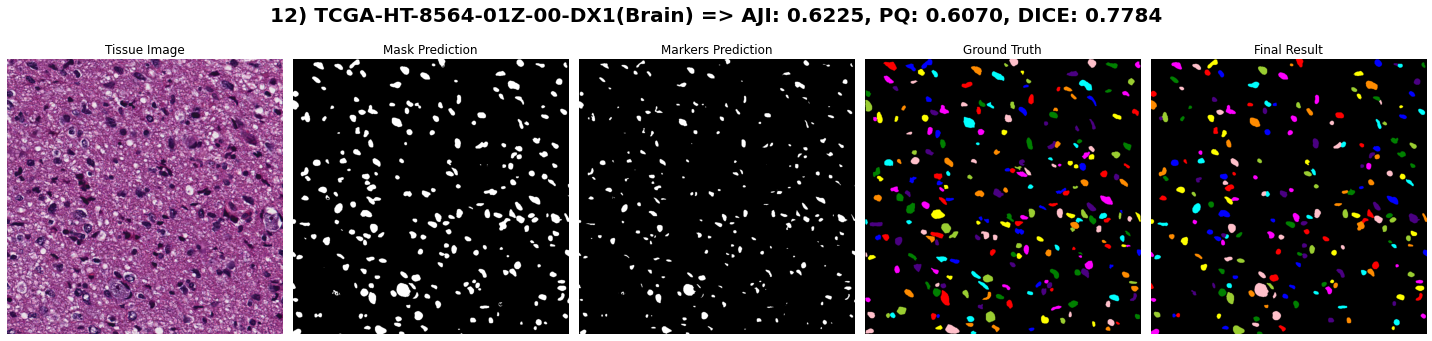

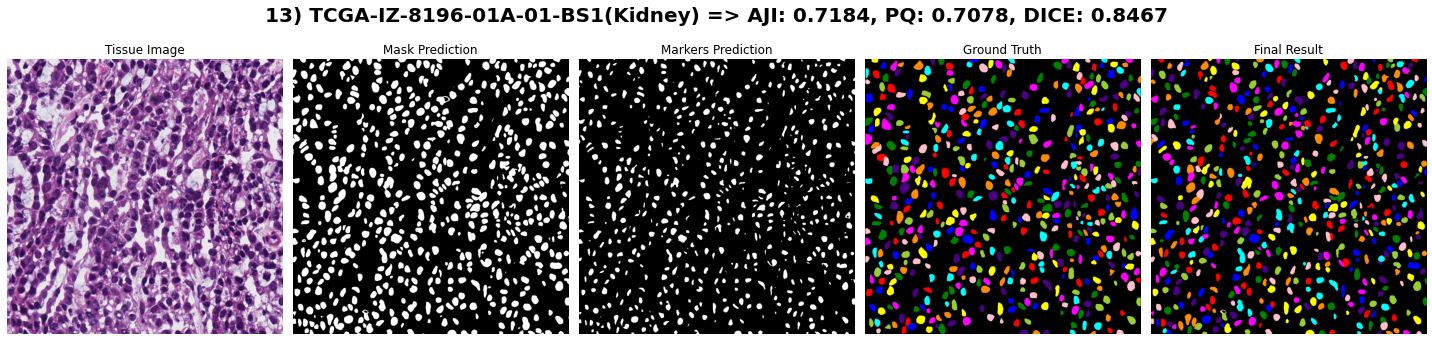

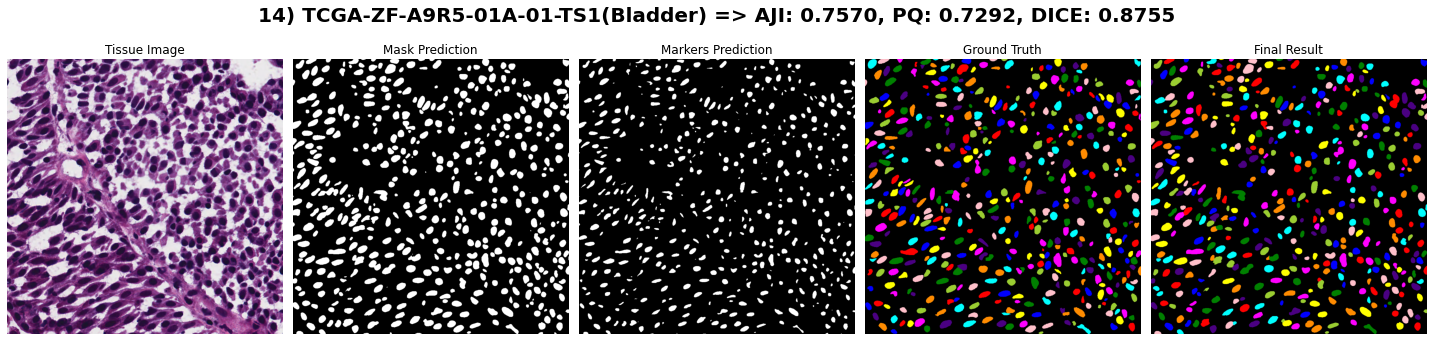

In [26]:
### for all the test images

BINARY_SCORE = []
MULTICLASS_SCORE = []
FINAL_SCORE = []

pre_proc_time = 0
pred_time = 0
tta_time = 0
post_proc_time = 0

n = 0

for image_path in sorted(glob.glob(os.path.join(test_img_dir, "*"))):

    n += 1

    """ extracting the name """
    name = os.path.basename(image_path)
    name = name.split(".")[0]

    """ preprocessing """
    start = time.time()
    # 1) stain normalization
    img, normI = macenko_normalize(image_path, ref_img_dir)
    # 2) resize to 1024 * 1024
    resizedI = cv2.resize(normI, (1024, 1024), cv2.INTER_LINEAR)
    # 3) pixel value normalize between [0, 1]
    normalizedI = resizedI.astype("float32") / 255.
    # 4) expand dimension
    normalizedI = np.expand_dims(normalizedI, axis=0)
    end = time.time()
    pre_proc_time += end - start

    """ make prediction """
    # binary_pred, multi_pred = model.predict(normalizedI, verbose=0)
    # make prediction with TTA (Test Time Augmentation)
    start = time.time()
    pred = model.predict(normalizedI, verbose=0)
    end = time.time()
    pred_time += end - start
    binary_pred_org = pred[0]
    multi_pred_org = pred[5]
    
    pred_lr = model.predict(np.fliplr(normalizedI), verbose=0)
    binary_pred_lr = pred_lr[0]
    multi_pred_lr = pred_lr[5]
    binary_pred_lr = np.fliplr(binary_pred_lr)
    multi_pred_lr = np.fliplr(multi_pred_lr)

    pred_ud = model.predict(np.flipud(normalizedI), verbose=0)
    binary_pred_ud = pred_ud[0]
    multi_pred_ud = pred_ud[5]
    binary_pred_ud = np.flipud(binary_pred_ud)
    multi_pred_ud = np.flipud(multi_pred_ud)

    pred_lr_ud = model.predict(np.fliplr(np.flipud(normalizedI)), verbose=0)
    binary_pred_lr_ud = pred_lr_ud[0]
    multi_pred_lr_ud = pred_lr_ud[5]
    binary_pred_lr_ud = np.fliplr(np.flipud(binary_pred_lr_ud))
    multi_pred_lr_ud = np.fliplr(np.flipud(multi_pred_lr_ud))

    binary_pred = (binary_pred_org + binary_pred_lr + binary_pred_ud + binary_pred_lr_ud) / 4
    multi_pred = (multi_pred_org + multi_pred_lr + multi_pred_ud + multi_pred_lr_ud) / 4
    end = time.time()
    tta_time += end - start

    # resize to 1000 * 1000
    resized_pred_1 = cv2.resize(binary_pred.squeeze(), (1000, 1000))
    resized_pred_2 = cv2.resize(multi_pred.squeeze(), (1000, 1000))

    # threshold
    start = time.time()
    pred = resized_pred_1 >= 0.5
    pred = pred.astype("int32")

    pred_2 = resized_pred_2 >= 0.5
    pred_2 = pred_2.astype("int32")
    onehot_mask = np.argmax(pred_2, axis=-1)

    # post_processing
    marker_pred = (resized_pred_2[:, :, 2] - resized_pred_2[:, :, 1]) >= 0.5
    marker_pred = morphology.binary_erosion(marker_pred)
    marker_pred = marker_pred.astype("int32")

    grad = filters.scharr(pred)
    marker = pred * marker_pred
    marker_label = measurements.label(marker)[0]
    proced_pred = watershed(grad, marker_label, mask=pred)
    proced_pred = morphology.remove_small_objects(proced_pred, 100)
    binary_objects = proced_pred.astype(bool)
    binary_filled = morphology.remove_small_holes(binary_objects, 40)
    proced_pred = watershed(binary_filled, proced_pred, mask=binary_filled)
    end = time.time()
    post_proc_time += end - start

    # read the mask
    binary_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "binary_masks").replace("tif", "png")
    binary_gt = cv2.imread(binary_mask_path, 0)

    multi_mask_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "modified_masks").replace("tif", "png")
    multi_gt = cv2.imread(multi_mask_path, 0)
    multi_gt[multi_gt==255] = 2
    multi_gt[multi_gt==127] = 1

    instance_gt_path = image_path.replace("original", 
                                          "stain_normalized").replace("tissue_images", 
                                                                      "instance_masks").replace("tif", "npy")

    color_pred = label2rgb(proced_pred, bg_label=0)
    ins_gt = np.load(instance_gt_path)
    color_gt = label2rgb(ins_gt, bg_label=0)

    # evaluate
    mask = binary_gt.flatten()
    y_pred = pred.flatten()

    f1_value = f1_score(mask/255, y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(mask/255, y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)
    precision_value = precision_score(mask/255, y_pred, labels=[0, 1], average="binary", zero_division=0)

    mask_2 = multi_gt.flatten()
    y_pred_2 = onehot_mask.flatten()

    f1_value_2 = f1_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    jac_value_2 = jaccard_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None)
    recall_value_2 = recall_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)
    precision_value_2 = precision_score(mask_2, y_pred_2, labels=[0, 1, 2], average=None, zero_division=0)

    proced_pred = remap_label(proced_pred)
    gt_remap = remap_label(ins_gt.astype("int32"))
    fast_aji = get_fast_aji(gt_remap, proced_pred)
    aji = AJI_Metrics()
    reg_aji= aji.add_prediction(proced_pred, ins_gt)
    score = get_fast_pq(gt_remap, proced_pred)
    dice_score = get_dice_1(gt_remap, proced_pred)
    dice2 = get_fast_dice_2(gt_remap, proced_pred)
    
    # append to SCORE
    BINARY_SCORE.append([name, f1_value, jac_value, recall_value, precision_value])
    binary_df = pd.DataFrame(BINARY_SCORE, columns=["Image", "F1", "Jaccard", "Recall", "Precision"])

    MULTICLASS_SCORE.append([
                             name, 
                             f1_value_2[0], f1_value_2[1], f1_value_2[2],
                             jac_value_2[0], jac_value_2[1], jac_value_2[2],
                             recall_value_2[0], recall_value_2[1], recall_value_2[2],
                             precision_value_2[0], precision_value_2[1], precision_value_2[2],
                             ])
    multi_class_df = pd.DataFrame(MULTICLASS_SCORE, columns=["Image", 
                                                             "F1_bg", "F1_border", "F1_marker",
                                                             "Jaccard_bg", "Jaccard_border", "Jaccard_marker",
                                                             "Recall_bg", "Recall_border", "Recall_marker",
                                                             "Precision_bg", "Precision_border", "Precision_marker"])
    
    FINAL_SCORE.append([name, fast_aji, reg_aji, score[0][0], score[0][1], score[0][2], dice_score, dice2])
    final_df = pd.DataFrame(FINAL_SCORE, columns=["Image", "fast_AJI", "AJI", "DQ/F1", "SQ", "PQ", "DICE", "DICE2"])

    fig, ax = plt.subplots(1, 5, figsize=(20, 5.5))
    [axi.axis(False) for axi in ax.ravel()]

    ax[0].imshow(img)
    ax[0].set_title("Tissue Image")

    ax[1].imshow(pred, cmap="gray")
    ax[1].set_title("Mask Prediction")

    ax[2].imshow(marker, cmap="gray")
    ax[2].set_title("Markers Prediction")

    ax[3].imshow(color_gt)
    ax[3].set_title("Ground Truth")

    ax[4].imshow(color_pred)
    ax[4].set_title("Final Result")

    plt.tight_layout()
    plt.suptitle(f"{n}) {name}({test_organs[n-1]}) => AJI: {reg_aji:.4f}, PQ: {score[0][2]:.4f}, DICE: {dice_score:.4f}", 
                 fontsize=20, fontweight='bold')
    plt.show()

In [27]:
print(f"Prediction time: {pred_time/14:.3f}s, TTA time: {tta_time/14:.3f}s, Post_processing time: {post_proc_time/14:.3f}s")

Prediction time: 0.828s, TTA time: 2.704s, Post_processing time: 0.137s


In [28]:
binary_df.loc['mean'] = binary_df.mean(numeric_only=True)
# binary_df.to_csv("binary_score_FTL.csv")
binary_df

Image        F1   Jaccard    Recall  Precision
0     TCGA-2Z-A9J9-01A-01-TS1  0.816548  0.689971  0.861104   0.776376
1     TCGA-44-2665-01B-06-BS6  0.860417  0.755028  0.837217   0.884940
2     TCGA-69-7764-01A-01-TS1  0.793833  0.658145  0.803186   0.784694
3     TCGA-A6-6782-01A-01-BS1  0.798823  0.665034  0.801700   0.795967
4     TCGA-AC-A2FO-01A-01-TS1  0.777386  0.635839  0.733038   0.827446
5     TCGA-AO-A0J2-01A-01-BSA  0.819439  0.694110  0.837278   0.802344
6     TCGA-CU-A0YN-01A-02-BSB  0.825330  0.702606  0.857476   0.795506
7     TCGA-EJ-A46H-01A-03-TSC  0.830142  0.709610  0.881675   0.784301
8     TCGA-FG-A4MU-01B-01-TS1  0.864755  0.761734  0.881888   0.848275
9     TCGA-GL-6846-01A-01-BS1  0.841088  0.725757  0.827592   0.855033
10    TCGA-HC-7209-01A-01-TS1  0.847153  0.734836  0.862234   0.832591
11    TCGA-HT-8564-01Z-00-DX1  0.786250  0.647786  0.709769   0.881206
12    TCGA-IZ-8196-01A-01-BS1  0.847293  0.735046  0.831863   0.863306
13    TCGA-ZF-A9R5-01A-01-TS1  0.877008  0.780956  0.879477   0.874552
mean                      NaN  0.827533  0.706890  0.828964   0.829038

In [29]:
multi_class_df.loc['mean'] = multi_class_df.mean(numeric_only=True)
# multi_class_df.to_csv("multi_class_FTL.csv")
multi_class_df

Image     F1_bg  F1_border  F1_marker  Jaccard_bg  \
0     TCGA-2Z-A9J9-01A-01-TS1  0.912099   0.747271   0.774993    0.838402   
1     TCGA-44-2665-01B-06-BS6  0.906588   0.800127   0.823598    0.829136   
2     TCGA-69-7764-01A-01-TS1  0.901048   0.702970   0.768581    0.819915   
3     TCGA-A6-6782-01A-01-BS1  0.937779   0.718492   0.756650    0.882847   
4     TCGA-AC-A2FO-01A-01-TS1  0.878809   0.668607   0.736654    0.783818   
5     TCGA-AO-A0J2-01A-01-BSA  0.913147   0.697787   0.795532    0.840175   
6     TCGA-CU-A0YN-01A-02-BSB  0.889811   0.765400   0.789548    0.801495   
7     TCGA-EJ-A46H-01A-03-TSC  0.939844   0.769683   0.795938    0.886514   
8     TCGA-FG-A4MU-01B-01-TS1  0.930971   0.764282   0.835504    0.870856   
9     TCGA-GL-6846-01A-01-BS1  0.938905   0.728291   0.812303    0.884846   
10    TCGA-HC-7209-01A-01-TS1  0.959094   0.758911   0.823029    0.921404   
11    TCGA-HT-8564-01Z-00-DX1  0.967965   0.692826   0.753103    0.937919   
12    TCGA-IZ-8196-01A-01-BS1  0.925364   0.766059   0.819190    0.861095   
13    TCGA-ZF-A9R5-01A-01-TS1  0.947884   0.790448   0.849378    0.900931   
mean                      NaN  0.924951   0.740797   0.795286    0.861382   

      Jaccard_border  Jaccard_marker  Recall_bg  Recall_border  Recall_marker  \
0           0.596514        0.632644   0.873848       0.785224       0.851209   
1           0.666842        0.700100   0.918077       0.797323       0.800758   
2           0.541985        0.624143   0.879590       0.756476       0.759719   
3           0.560662        0.608558   0.932136       0.730664       0.764397   
4           0.502187        0.583098   0.906168       0.657878       0.684819   
5           0.535847        0.660484   0.898491       0.715010       0.816476   
6           0.619958        0.652276   0.849420       0.815276       0.821149   
7           0.625597        0.661044   0.910561       0.823553       0.856365   
8           0.618493        0.717482   0.904683       0.796456       0.874383   
9           0.572687        0.683932   0.935608       0.739304       0.809022   
10          0.611487        0.699278   0.955299       0.763413       0.838682   
11          0.530018        0.603981   0.985501       0.637143       0.689516   
12          0.620823        0.693753   0.913894       0.786357       0.823233   
13          0.653504        0.738190   0.948540       0.789805       0.847836   
mean        0.589757        0.661354   0.915130       0.756706       0.802683   

      Precision_bg  Precision_border  Precision_marker  
0         0.953851          0.712818          0.711305  
1         0.895382          0.802950          0.847780  
2         0.923579          0.656534          0.777653  
3         0.943490          0.706720          0.749059  
4         0.853054          0.679692          0.796978  
5         0.928290          0.681375          0.775636  
6         0.934235          0.721274          0.760290  
7         0.971072          0.722428          0.743477  
8         0.958833          0.734607          0.799936  
9         0.942226          0.717601          0.815611  
10        0.962920          0.754461          0.807950  
11        0.951042          0.759172          0.829609  
12        0.937126          0.746782          0.815187  
13        0.947229          0.791091          0.850925  
mean      0.935881          0.727679          0.791528

In [30]:
final_df.loc['mean'] = final_df.mean(numeric_only=True)
# final_df.to_csv("results/Unet3+/FINAL_SCORE.csv")
final_df

Image  fast_AJI       AJI     DQ/F1        SQ  \
0     TCGA-2Z-A9J9-01A-01-TS1  0.646360  0.654444  0.838273  0.761701   
1     TCGA-44-2665-01B-06-BS6  0.697992  0.705424  0.898890  0.792938   
2     TCGA-69-7764-01A-01-TS1  0.632802  0.627427  0.803571  0.762357   
3     TCGA-A6-6782-01A-01-BS1  0.598840  0.600652  0.811859  0.738431   
4     TCGA-AC-A2FO-01A-01-TS1  0.600567  0.600160  0.793591  0.730878   
5     TCGA-AO-A0J2-01A-01-BSA  0.631320  0.642145  0.810093  0.759462   
6     TCGA-CU-A0YN-01A-02-BSB  0.656245  0.659466  0.852113  0.779453   
7     TCGA-EJ-A46H-01A-03-TSC  0.665103  0.676759  0.866803  0.790353   
8     TCGA-FG-A4MU-01B-01-TS1  0.693540  0.696443  0.854410  0.784583   
9     TCGA-GL-6846-01A-01-BS1  0.707416  0.707682  0.894309  0.780083   
10    TCGA-HC-7209-01A-01-TS1  0.677458  0.668527  0.832579  0.777160   
11    TCGA-HT-8564-01Z-00-DX1  0.619385  0.622502  0.840517  0.722159   
12    TCGA-IZ-8196-01A-01-BS1  0.717818  0.718356  0.911051  0.776889   
13    TCGA-ZF-A9R5-01A-01-TS1  0.753003  0.757023  0.920635  0.792058   
mean                      NaN  0.664132  0.666929  0.852050  0.767750   

            PQ      DICE     DICE2  
0     0.638513  0.817270  0.752337  
1     0.712765  0.860160  0.697666  
2     0.612609  0.798994  0.744627  
3     0.599501  0.796827  0.754471  
4     0.580018  0.777333  0.738692  
5     0.615235  0.820268  0.747390  
6     0.664182  0.825827  0.789182  
7     0.685080  0.833689  0.783337  
8     0.670356  0.866447  0.767250  
9     0.697635  0.842796  0.752265  
10    0.647047  0.845264  0.742144  
11    0.606987  0.778351  0.797257  
12    0.707785  0.846707  0.817957  
13    0.729196  0.875536  0.847486  
mean  0.654779  0.827534  0.766576